In [2]:
import pickle

In [3]:
dataset = pickle.load( open( "save.p", "rb" ) )

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw

def draw_image(strokes_list):
    im = Image.new(mode="1", size=(500,500))

    draw = ImageDraw.Draw(im)
    #draw.moveTo(strokes[0][:2], fill=128)
    #print(strokes)
    #draw.line((0, 0) + im.size, fill=128)
    #draw.line((0, im.size[1], im.size[0], 0), fill=128)
    for strokes in strokes_list:
        draw.line(strokes, fill=128, width=5)
    
    
    #for stroke in strokes[0:]:
        #print(stroke.tolist())
        #draw.line(stroke, fill=128, width=10)

    plt.imshow(im)

In [5]:
list(map(lambda a: print(len(a)), dataset[1]))
print("")
reduced = list(map(lambda a: dominant(alpha,a), dataset[1]))
list(map(lambda a: print(len(a)), reduced))

347
91
116



NameError: name 'dominant' is not defined

In [ ]:
list(map(smooth, dataset[1]))

In [ ]:
alpha = 2*math.pi*15/360
print(alpha)

draw_image(dataset[1])
plt.show()
#draw_image(list(map(lambda a: dominant(alpha,a), dataset[1])))
draw_image(list(map(smooth, dataset[1])))
plt.show()

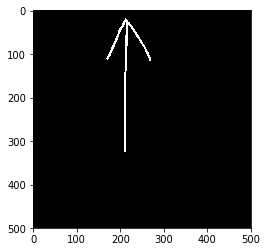

In [6]:
draw_image(dataset[0])

In [7]:
"""sanitize = (map (dominant alpha
                .unduplicate
                .redistribute 10
                .aspectrefit (Point (0,0), Point (1,1))
                .smooth
                .unduplicate)
                ).limit 10"""

#Take only the first ten stroke lines

'sanitize = (map (dominant alpha\n                .unduplicate\n                .redistribute 10\n                .aspectrefit (Point (0,0), Point (1,1))\n                .smooth\n                .unduplicate)\n                ).limit 10'

In [8]:
import numpy as np
from numpy.linalg import norm
from math import acos

def angle(x, y, z):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    w = z - y
    v = y - x
    #fix_domain()
    return acos(min(max(v.dot(w)/(norm(v) * norm(w)), -1),1))

#dominant alpha s@(x:y:z:ps) = x:(dominant' alpha s) where
def dominant(alpha, strokes):
    
    if len(strokes) < 3:
        return strokes
    
    return [strokes[0]] + dominant_(alpha, strokes)

#dominant' alpha (x:y:z:ps) | angle x y z < alpha = dominant' alpha (x:z:ps)
#                           | otherwise = y:(dominant' alpha (y:z:ps))
#dominant' _ (x:ps) = ps
def dominant_(alpha, strokes):
    if len(strokes) < 3:
        return strokes[1:]
    
    x = strokes[0]
    y = strokes[1]
    z = strokes[2]
    ps = strokes[3:]
    
    #If the angle between the links are too small, the middle point is kind of irrelevant, we may remove it
    if angle(x,y,z) < alpha:
        return dominant_(alpha, [x] + [z] + ps)
    
    return [y] + dominant_(alpha, [y] + [z] + ps)

In [9]:
#-- remove successive duplicate (similar) points
#unduplicate :: Stroke -> Stroke
#unduplicate [] = []
#unduplicate [p] = [p]
#unduplicate (p:q:ps) | p ~~ q    = unduplicate (p:ps)
#                     | otherwise = p:(unduplicate (q:ps))

def unduplicate(strokes):
    if len(strokes) < 2:
        return strokes
    
    if strokes[0] == strokes[1]:
        return unduplicate(strokes[1:])
    else:
        return strokes[0:1] + unduplicate(strokes[1:])
    
test_strokes = [
    [200,200],
    [200,400],
    [400,800]
]

unduplicate(test_strokes)

[[200, 200], [200, 400], [400, 800]]

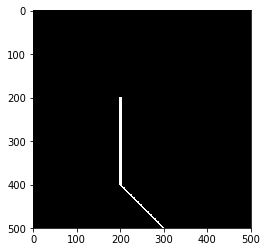

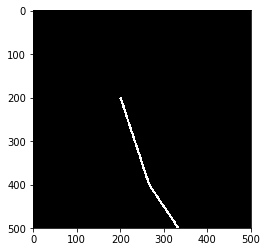

In [10]:
#-- smooth
#smooth :: Stroke -> Stroke
#smooth s@(x:y:z:ps) = x:(smooth' s) where
#  smooth' (x:y:z:ps) = ((1/3) `scalar` (x `add` y `add` z)):(smooth' (y:z:ps))
#  smooth' (x:ps) = ps
#smooth ps = ps

def smooth(strokes):
    return [strokes[0]] + smooth_(strokes)

def smooth_(strokes):
    if len(strokes) < 3:
        return strokes[1:]
    
    x = np.array(strokes[0])
    y = np.array(strokes[1])
    z = np.array(strokes[2])
    
    w = (x+y+z)/3
    
    return [tuple(w)] + smooth_(strokes[1:])

test_strokes = [
    (200,200),
    (200,400),
    (400,600),
]

draw_image([test_strokes])
plt.show()
draw_image([smooth(test_strokes)])
plt.show()

In [11]:
#-- redistribute to equidistant series by number of points
#-- this might go wrong due to numeric inaccuracy (esp. for large n)
#-- but together with unduplicate it should work well enough
#redistribute :: Int -> Stroke -> Stroke
#-- degenerate cases
#redistribute _ [] = []
#redistribute _ [p] = [p]
#-- normal cases
#redistribute 0 _ = []
#redistribute 1 s = [head s]
#redistribute num stroke@(p:q:ps) = redistribute' dist stroke where
#  dist = (slength stroke) / ((fromIntegral num) - 1)

def redistribute(num, stroke):
    if num == 0:
        return []
    if num == 1:
        return [stroke[0]]
    
    dist_value = slength(stroke) / (num - 1)
    
    return redistribute_(dist_value, stroke)

#-- redistribute to equidistant series by distance
#redistribute' :: Double -> Stroke -> Stroke
#redistribute' dist _ | dist <= 0 = error "No Sir! No redistribution with non-positive distance!"
#redistribute' dist s@(p:q:ps) = p:(redist dist s) where -- first point always part of new stroke

#  redist :: Double -> Stroke -> Stroke
#  redist left (p:q:ps) | d < left = redist (left - d) (q:ps)
#                       | otherwise = ins:(redist dist (ins:q:ps))
#                         where
#                           dir = q `sub` p
#                           d = norm dir
#                           ins = p `add` ((left/d) `scalar` dir)
#  redist _ ps = ps -- done when only one left
#redistribute' _ ps = ps -- empty or single point strokes stay unmodified
def redistribute_(dist_value, stroke):
    
    def redist(left, stroke):
        if len(stroke) < 2:
            return stroke
        
        p = np.array(stroke[0])
        q = np.array(stroke[1])

        dir_ = q - p
        d = norm(dir_)


        if d < left:
            return redist((left-d), stroke[1:])
        else:
            ins = p + ((left/d) * dir_)
            return [tuple(ins)] + redist(dist_value, [ins] + stroke[1:])
        
    assert dist_value > 0
    
    if len(stroke) < 2:
        return stroke
    
    return [stroke[0]] + redist(dist_value, stroke)
        
redistribute(3, test_strokes)

NameError: name 'slength' is not defined

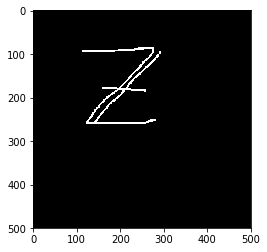

NameError: name 'slength' is not defined

In [12]:
draw_image(dataset[100])
plt.show()
draw_image(list(map(lambda a: redistribute(10,a), dataset[100])))
plt.show()

In [13]:
#slength :: Stroke -> Double
#slength (p:q:ps) = p `dist` q + (slength (q:ps))
#slength _ = 0

def slength(strokes):
    if len(strokes) < 2:
        return 0
    
    return dist(strokes[0], strokes[1]) + slength(strokes[1:])

def dist(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return norm(v1-v2)

slength(test_strokes)

482.842712474619

In [14]:
def bounding_box(stroke):
    min_x = math.inf
    min_y = math.inf
    max_x = -math.inf
    max_y = -math.inf
    for x, y in stroke:
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x)
        max_y = max(max_y, y)
        
    return [(min_x, min_y), (max_x, max_y)]

bounding_box(dataset[100][0])
    

NameError: name 'math' is not defined

In [15]:
#aspectrefit :: Rect -> Stroke -> Stroke
#aspectrefit r s = refit (aspectfit (boundingbox s) r) s

def aspect_refit(r, s):
    return refit(aspect_fit(bounding_box(s), r), s)

In [16]:
#-- fit into rect (x1, y1, x2, y2)
#refit :: Rect -> Stroke -> Stroke
#refit (Point (x1, y1), Point (x2, y2)) _ | x1 > x2 || y1 > y2 = error "Dude! Your rect doesn't make sense!"
#refit _ [] = [] 
#refit (Point (x1, y1), Point (x2, y2)) stroke = for stroke $ \p -> (scale scaleX scaleY (p `sub` reset)) `add` trans
#  where
#    (Point (bbx1, bby1), Point (bbx2, bby2)) = boundingbox stroke
#    reset = Point (bbx1, bby1)
#    bbWidth = bbx2 - bbx1
#    bbHeight = bby2 - bby1
#    targetWidth = x2 - x1
#    targetHeight = y2 - y1
#    scaleX = case bbWidth of
#      0 -> 1
#      width -> 1/width * targetWidth
#    scaleY = case bbHeight of
#      0 -> 1
#      height -> 1/height * targetHeight
#    transX = case bbWidth of
#      0 -> x1 + 1/2 * targetWidth
#      width -> x1
#    transY = case bbHeight of
#      0 -> y1 + 1/2 * targetHeight
#      height -> y1
#    trans = Point (transX, transY)

def refit(r, stroke):
    if len(stroke) == 0:
        return stroke
    
    (x1, y1), (x2, y2) = r
    assert x1 < x2 && y1 < y2
    
    return 

SyntaxError: invalid syntax (<ipython-input-16-19d501005adb>, line 32)

In [17]:
#-- fit the first rect maximally and centered into the second rect keeping the aspect ratio
#aspectfit :: Rect -> Rect -> Rect
#aspectfit source@(a, b) target@(c, d) | a == b = ((1/2) `scalar` (c `add` d), (1/2) `scalar` (c `add` d))
#                                      | otherwise = both reposition source where
#  reset = fst source
#  sourcewidth = width source
#  sourceheight = height source
#  targetwidth = width target
#  targetheight = height target
#  sourceratio = sourcewidth/sourceheight
#  targetratio = targetwidth/targetheight
#  -- bigger ratio <~> wider
#  sourcewider = sourceratio > targetratio
#  scalefactor | sourcewider = 1/sourcewidth*targetwidth -- scale to fit width of target and center
#              | otherwise   = 1/sourceheight*targetheight
#  offset      | sourcewider = Point (0, (targetheight - scalefactor*sourceheight)/2)
#              | otherwise   = Point ((targetwidth - scalefactor*sourcewidth)/2, 0)
#  reposition p = (scale scalefactor scalefactor (p `sub` reset)) `add` offset `add` (fst target)

def both(f, l):
    a,b = l
    return (f(a), f(b))

def aspect_fit(source, target):
    a, b = np.array(source)
    c, d = np.array(target)
    
    if np.array_equal(a,b):
        return 0.5*(c+d), 0.5*(c+d)
    else:
        def reposition(p):
            reset = source[0]
            sourcewidth = source[1][0] - source[0][0]
            sourceheight = source[1][1] - source[0][1]
            targetwidth = target[1][0] - target[0][0]
            targetheight = target[1][1] - target[0][1]
            sourceratio = sourcewidth/sourceheight
            targetratio = targetwidth/targetheight
            
            sourcewider = sourceratio > targetratio
            
            if sourcewider:
                scalefactor = targetwidth/sourcewidth #scale to fit width of target and center
                offset = (0, (targetheight - scalefactor*sourceheight)/2)
            else:
                scalefactor = targetheight/sourceheight
                offset = ((targetwidth - scalefactor*sourcewidth)/2, 0)
            
            offset = np.array(offset)
            
            return scale_factor * (p-reset) + offset + target[0]
        
        
        return both(reposition, source)
        

In [18]:
#vendomorphism :: ((Double, Double), (Double, Double)) -> Point -> Point
#vendomorphism ((a11, a12), (a21, a22)) (Point (x, y)) = Point (a11*x + a12*y, a21*x + a22*y)
#def vendomorphism(a, p):
    #(a11, a12), (a21, a22) = a
    #x, y = p
    #return (a11*x + a12*y, a21*x + a22*y)

#scale :: Double -> Double -> Point -> Point
#scale x y = vendomorphism ((x, 0), (0, y))
#def scale(x, y):
    #return vendomorphism ((x, 0), (0, y))

In [19]:
test_strokes = [
    [200,200],
    [200,400],
    [400,800]
]

dominant(0.4, test_strokes)

[[200, 200], [200, 400], [400, 800]]

In [20]:
x = np.array([0,0])
y = np.array([2,2])
z = np.array([4,8])

angle(x,y,z)

0.46364760900080615

In [21]:
2*math.pi*15/360

NameError: name 'math' is not defined